# N-Tuple Learning with Monte Carlo methods

Created 2025-07-17

*Summary*: The original n-tuple network was not working well. The idea is to switch to MC and try some new ideas:
- Instead of TD learning, use Monte Carlo methods and train the model _after_ the episode
    - This should also increase the training speed
- Predict the value function instead of the action value function
- Update towards the final reward (and not the reward from step n to n+1).
    - May fix the problem that the agent is prefering low merges due to immediate reward, while the optimal solution is mostly to wait for a higher merge
    - Combined with the switch to a value function the score gets a meaning: The average score given the current board

In [1]:
import numpy as np
import sys
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
import ipywidgets as widgets
from ipyevents import Event
import time
import gymnasium as gym
import torch
import torch.nn as nn
from typing import Any, cast
from collections import deque
import random
import cv2
from IPython.display import HTML
from matplotlib.patches import FancyArrow

In [2]:
sys.path.insert(1, str(Path("../..")))
from andreas2048.game import *
from andreas2048 import gym2048
env = gym2048.Env2048()

In [3]:
raise RuntimeError("STOP")

RuntimeError: STOP

### 1: Neuronal n7-Tuple Network 

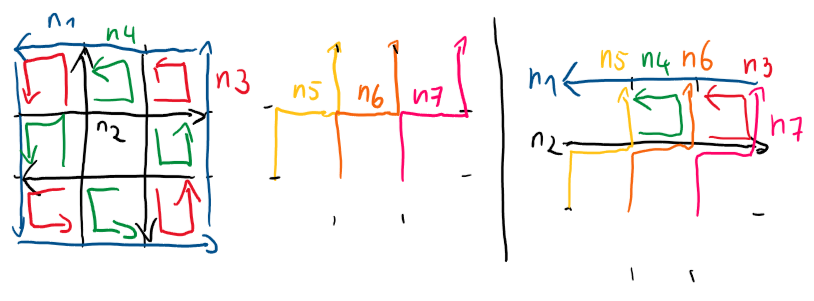

Because the first tests with n-Tuple Networks did not show good performance, a new architecture is implemented called n7-Tuple Networks. For each of the 4 rotations 7 tuples are defined each. The tuples are defined in a way to guide the network into a specific corner (e.g. in the figure above to the upper left corner). Due to rotation symmetry most of the potential tuples should be encoded this way. 

With the new game logic Monte Carlo is implemented with updates after each episode for each of the states visited. The architecture will be implemented as a Neuronal Network. The idea to traditional table approaches is that the model may learn about tuples not visited yet (e.g. higher values). It is yet not clear if the network should be symmetric for each of the 4 rotations or if the 28 tuples are allowed to have different weights each. It will be started with the first approach.

In [ ]:
# Test the extract tuples function (for implementation in the DQN class)
def extract_tuples(grid: np.ndarray):
    """
    Extract the n-tuples from n boards of shape (n, 4, 4). Returns the tuples as a numpy array of shape \n
    (n, ||n_tuple||, 4, 4) = (n, 7, 4, 4) \n
    with the third value representing the rotation (Top, Right, Bottom, Left) and the last values the ith value inside the n-tuple
    """
    assert len(grid.shape) >= 3 and grid.shape[1] == 4 and grid.shape[2] == 4
    n_tuples = np.zeros(shape=(grid.shape[0],7,4,4), dtype=grid.dtype)
    for k in range(4):
        g_v = np.rot90(grid, k=k, axes=(1,2))
        n_tuples[:,0,k] = g_v[:,0,::-1] # Outer
        n_tuples[:,1,k] = g_v[:,1,:: 1] # Inner
        n_tuples[:,2,k] = g_v[:, [1,1,0,0], [-2,-1,-1,-2]] # Edge
        n_tuples[:,3,k] = g_v[:, [1,1,0,0], [-3,-2,-2,-3]] # Inner Edge
        n_tuples[:,4,k] = g_v[:, [2,1,1,0], [0,0,1,1]] # Left Z
        n_tuples[:,5,k] = g_v[:, [2,1,1,0], [1,1,2,2]] # Middle Z
        n_tuples[:,6,k] = g_v[:, [2,1,1,0], [2,2,3,3]] # Right Z
    return n_tuples

extract_tuples(np.arange(0,16).reshape(1,4,4)).shape
# Yeah, is working

(1, 7, 4, 4)

The weights of the tuples are encoded with two Conv2D layers designed to apply the same weights to each rotation symmetry. After that, 1 hidden layer (128 -> 64) is used

In [ ]:
class DQN(nn.Module):
    """ DQN implementation for a 2048 grid """

    def __init__(self, grid_shape: tuple[int, int], device: str) -> None:
        super().__init__()
        self.device = device
        assert grid_shape == (4,4)

        self.weight_mean = 100
        self.weight_width = 50

        #self.c1 = nn.Conv2d(in_channels=7, out_channels=7, kernel_size=(1,2))
        #self.c2 = nn.Conv2d(in_channels=7, out_channels=7, kernel_size=(1,2))
        #self.c3 = nn.Conv2d(in_channels=7, out_channels=7, kernel_size=(1,3))
        #self.c4 = nn.Conv2d(in_channels=7, out_channels=7, kernel_size=(1,4))

        self.net = nn.Sequential(
            nn.Conv2d(in_channels=7, out_channels=7, kernel_size=(1,1)), # (n,7,4,4) -> (n,7,4,4)
            nn.Conv2d(in_channels=7, out_channels=7, kernel_size=(1,4)), # (n,7,4,4) -> (n,7,4,1)
            nn.Flatten(), # (n,7,4,1) -> (n,28)
            nn.Linear(in_features=28, out_features=128),
            nn.Linear(in_features=128, out_features=64),
            nn.Linear(in_features=64, out_features=1),
        )
        self.net.to(self.device)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """ Expects tensor of shape (n,7,4,4) """
        return self.net.forward(x)
    
    def V(self, x: np.ndarray, output_tensor: bool = False) -> np.ndarray|torch.Tensor:
        """ 
        Outputs the value function estimation by the model

        Args:
            x (np.ndarray): n-boards of shape (n,4,4) 

        Returns:
            V (np.ndarray): The value of the n-boards encoded as numpy array with shape (n,)
        
        """
        while len(x.shape) < 3: # (4,4) -> (1,4,4)
            x = x[None, :]
        x = self.extract_tuples(x) # (n,4,4) -> (n,7,4,4)
        t = torch.from_numpy(x).float().to(self.device)
        #with torch.no_grad():
        vs = self.forward(t)
        vs = vs.squeeze()
        if output_tensor:
            return vs
        return vs.detach().numpy()
    

    def extract_tuples(self, grid: np.ndarray) -> np.ndarray:
        """
        Extract the n-tuples from n boards of shape (n, 4, 4). Returns the tuples as a numpy array of shape \n
        (n, ||n_tuple||, 4, 4) = (n, 7, 4, 4) \n
        with the third value representing the rotation (Top, Right, Bottom, Left) and the last values the ith value inside the n-tuple
        """
        assert len(grid.shape) >= 3 and grid.shape[1] == 4 and grid.shape[2] == 4
        n_tuples = np.zeros(shape=(grid.shape[0],7,4,4), dtype=grid.dtype)
        for k in range(4):
            g_v = np.rot90(grid, k=k, axes=(1,2))
            n_tuples[:,0,k] = g_v[:,0,::-1] # Outer
            n_tuples[:,1,k] = g_v[:,1,:: 1] # Inner
            n_tuples[:,2,k] = g_v[:, [1,1,0,0], [-2,-1,-1,-2]] # Edge
            n_tuples[:,3,k] = g_v[:, [1,1,0,0], [-3,-2,-2,-3]] # Inner Edge
            n_tuples[:,4,k] = g_v[:, [2,1,1,0], [0,0,1,1]] # Left Z
            n_tuples[:,5,k] = g_v[:, [2,1,1,0], [1,1,2,2]] # Middle Z
            n_tuples[:,6,k] = g_v[:, [2,1,1,0], [2,2,3,3]] # Right Z
        return n_tuples



In [ ]:
net = DQN(grid_shape=env.game.grid.shape, device="cpu")
print(env.game)
net.V(env.game.state.grid)

<2048 Game: score: 672 - moves: 84 - highest tile: 64>
[[ 0  4 32  8]
 [ 0  2 16 16]
 [ 2 32 64  2]
 [ 0  4  4  8]]


array(-0.21495605, dtype=float32)

In [ ]:
class DQNAgent:
    """ Implements a simple DQN agent """
    
    def __init__( self,
                env: gym2048.Env2048, 
                learning_rate: float = 0.05, 
                gamma: float = 0.99,
                epsilon: float = 1.0,
                epsilon_decay = 0.005,
                epsilon_min = 0.001,
               ) -> None:
        self.env = env
        self.device = "cpu" #torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = DQN(grid_shape=env.game.grid.shape, device=self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.gamma = gamma
        self.history: list[Game] = []

    def reset(self) -> None:
        env.reset()
        self.history.append(env.game)

    def update(self, game: Game) -> None:
        states = np.array([s.grid for s in game.history])
        scores = np.array([game.score for i in range(len(game.history))])
        #weight_fn = lambda score: 0.2 + 0.8/(1+np.exp(-(np.log(score+1)-self.model.weight_mean)/self.model.weight_width))
        #weights = np.array([weight_fn(s.score) for s in game.history])
        scores = torch.from_numpy(scores).float().to(self.device)
        #weights = torch.from_numpy(weights).float().to(self.device)
        vs = cast(torch.Tensor, self.model.V(states, output_tensor=True))
        loss = nn.MSELoss()(vs, scores)
        #loss = (weights * (vs - scores) ** 2).mean()
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def step(self) -> bool:
        possible_moves = self.env.game.get_moves()
        mask = np.array([(1 if a in possible_moves else 0) for a in Action])
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample(mask=mask)
        actions = self.get_qv()
        action = max(actions, key=actions.get)
        next_state, reward, done, truncated, info = env.step(action)
        return done or truncated
    
    def get_qv(self) -> dict[Action, float]:
        r = {}
        for a in Action:
            next_states = self.env.game.state.get_next_states(a)
            if len(next_states) == 1:
                continue
            next_states_grid = np.array([s.grid for s in next_states.keys()])
            qvs = self.model.V(next_states_grid)
            #print([(p, qv, "\n---\n") for p, qv in zip(next_states.values(), qvs)])
            r[a] = np.sum([p*qv for p, qv in zip(next_states.values(), qvs)])
        return r
    
    @property
    def scores(self) -> list[float]:
        return [g.score for g in self.history]
    
    @property
    def highest_tiles(self) -> list[int]:
        return [g.highest_tile for g in self.history]
    
    @property
    def move_counts(self) -> list[int]:
        return [g.move_count for g in self.history] 
    
    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * (1 - self.epsilon_decay))


    def adjust_training_weights(self) -> None:
        self.model.weight_mean = np.log(max(100, np.mean(self.scores[-500:])))
        self.model.weight_width = 2


env = gym2048.Env2048(shape=(4,4))
agent = DQNAgent(env=env, gamma=0.99, epsilon=0.05, epsilon_decay=0)
episode = -1

Episode 0/2000 - Score: 844 - Highest tile: 64 - Length: 108 - Epsilon: 0.050 - Average rolling score: 844.000 - Weights: 100.0+-50.0
Episode 1/2000 - Score: 940 - Highest tile: 64 - Length: 115 - Epsilon: 0.050 - Average rolling score: 892.000 - Weights: 100.0+-50.0
Episode 2/2000 - Score: 1580 - Highest tile: 128 - Length: 164 - Epsilon: 0.050 - Average rolling score: 1121.333 - Weights: 100.0+-50.0
Episode 3/2000 - Score: 676 - Highest tile: 64 - Length: 90 - Epsilon: 0.050 - Average rolling score: 1010.000 - Weights: 100.0+-50.0
Episode 4/2000 - Score: 716 - Highest tile: 64 - Length: 94 - Epsilon: 0.050 - Average rolling score: 951.200 - Weights: 100.0+-50.0
Episode 5/2000 - Score: 2132 - Highest tile: 128 - Length: 199 - Epsilon: 0.050 - Average rolling score: 1148.000 - Weights: 100.0+-50.0
Episode 6/2000 - Score: 2544 - Highest tile: 128 - Length: 236 - Epsilon: 0.050 - Average rolling score: 1347.429 - Weights: 100.0+-50.0
Episode 7/2000 - Score: 804 - Highest tile: 64 - Lengt

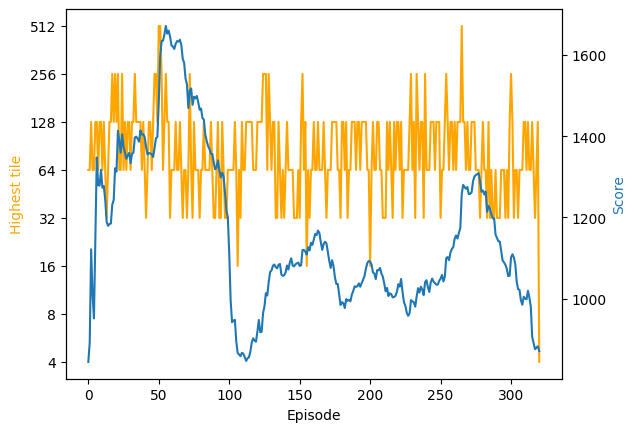

In [ ]:
episode += 1
episode_cap = 2000
try:
    for episode in range(episode, episode_cap):
        agent.reset()

        while env.game.alive:
            done = agent.step()
        agent.update(env.game)
        agent.decay_epsilon()
        #agent.adjust_training_weights()

        s = f"Episode {episode}/{episode_cap}"
        for lbl, v in [
            ("Score", env.game.score), 
            ("Highest tile", env.game.highest_tile), 
            ("Length", env.game.move_count), 
            ("Epsilon", f"{agent.epsilon:1.3f}"),
            ("Average rolling score", f"{np.mean(agent.scores[max(0,episode-50):]):1.3f}"),
            ("Weights", f"{agent.model.weight_mean:1.1f}+-{agent.model.weight_width:1.1f}")
        ]:
            s += f" - {lbl}: {v}"
        print(s)

except KeyboardInterrupt:
    pass

ax1 = plt.subplot()
ax2 = ax1.twinx()
p1 = ax1.plot(np.log2(agent.highest_tiles), label="Highest tile", c="orange")
scores = agent.scores
p2 = ax2.plot([np.mean(scores[max(0,i-50):i]) for i in range(1,len(scores)+1)], label="Scores")
ax1.set_xlabel("Episode")
ax1.set_ylabel("Highest tile")
ax2.set_ylabel("Score")
ax1.yaxis.label.set_color(p1[0].get_color())
ax2.yaxis.label.set_color(p2[0].get_color())
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{2**x:n}"))
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

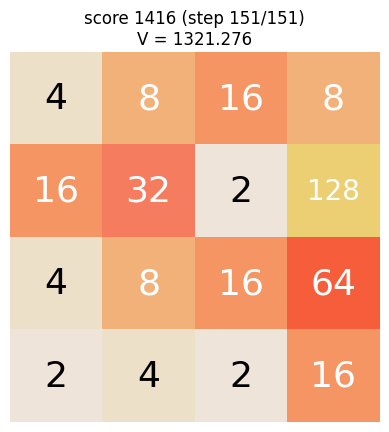

In [ ]:
HTML(agent.history[-2].render_game(value_func=lambda x: f"V = {agent.model.V(x):1.3f}").to_jshtml())

In [ ]:
#env.game.render_game(value_func=lambda x: f"V = {agent.model.V(x):1.3f}").save(Path(r"C:\Users\abril\OneDrive - JGU\Studium\Aktuelle Module\Reinforcement Learning SoSe25\Projekt\Videos\2025-07-19 first working model.mp4"))

In [ ]:
plt.plot()

In [ ]:
g_best = sorted(agent.history, key=lambda g:g.score, reverse=True)[0]
print(g_best)
HTML(g_best.render_game(value_func=lambda x: f"V = {agent.model.V(x):1.3f}").to_jshtml())

### Training continue

In [ ]:
episode += 1
episode_cap = 2000
try:
    for episode in range(episode, episode_cap):
        agent.reset()
        env.game.history = [g_best.history[134].clone()]

        while env.game.alive:
            done = agent.step()
        agent.update(env.game)
        agent.decay_epsilon()
        #agent.adjust_training_weights()

        s = f"Episode {episode}/{episode_cap}"
        for lbl, v in [
            ("Score", env.game.score), 
            ("Highest tile", env.game.highest_tile), 
            ("Length", env.game.move_count), 
            ("Epsilon", f"{agent.epsilon:1.3f}"),
            ("Average rolling score", f"{np.mean(agent.scores[max(0,episode-50):]):1.3f}"),
            ("Weights", f"{agent.model.weight_mean:1.1f}+-{agent.model.weight_width:1.1f}")
        ]:
            s += f" - {lbl}: {v}"
        print(s)

except KeyboardInterrupt:
    pass

ax1 = plt.subplot()
ax2 = ax1.twinx()
p1 = ax1.plot(np.log2(agent.highest_tiles), label="Highest tile", c="orange")
scores = agent.scores
p2 = ax2.plot([np.mean(scores[max(0,i-50):i]) for i in range(1,len(scores)+1)], label="Scores")
ax1.set_xlabel("Episode")
ax1.set_ylabel("Highest tile")
ax2.set_ylabel("Score")
ax1.yaxis.label.set_color(p1[0].get_color())
ax2.yaxis.label.set_color(p2[0].get_color())
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{2**x:n}"))
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

In [ ]:
g_best = sorted(agent.history, key=lambda g:g.score, reverse=True)[0]
print(g_best)
HTML(g_best.render_game(value_func=lambda x: f"V = {agent.model.V(x):1.3f}").to_jshtml())

### 50:50 Training

In [ ]:
agent.epsilon = 0.1

In [ ]:
episode += 1
episode_cap = 5000
try:
    for episode in range(episode, episode_cap):
        agent.reset()

        s = f"Episode  {episode}/{episode_cap}"
        if len(agent.history) > 50 and random.random() < 0.5:
            random_game = random.sample(agent.history[-50:-1], k=1)[0]
            env.game.history = random_game.history[:len(random_game.history)//2]
            s = f"Resample {episode}/{episode_cap}"

        while env.game.alive:
            done = agent.step()
        agent.update(env.game)
        agent.decay_epsilon()
        #agent.adjust_training_weights()

        for lbl, v in [
            ("Score", env.game.score), 
            ("Highest tile", env.game.highest_tile), 
            ("Length", env.game.move_count), 
            ("Epsilon", f"{agent.epsilon:1.3f}"),
            ("Average rolling score", f"{np.mean(agent.scores[max(0,episode-50):]):1.3f}"),
            ("Weights", f"{agent.model.weight_mean:1.1f}+-{agent.model.weight_width:1.1f}")
        ]:
            s += f" - {lbl}: {v}"
        print(s)

except KeyboardInterrupt:
    pass

ax1 = plt.subplot()
ax2 = ax1.twinx()
p1 = ax1.plot(np.log2(agent.highest_tiles), label="Highest tile", c="orange")
scores = agent.scores
p2 = ax2.plot([np.mean(scores[max(0,i-50):i]) for i in range(1,len(scores)+1)], label="Scores")
ax1.set_xlabel("Episode")
ax1.set_ylabel("Highest tile")
ax2.set_ylabel("Score")
ax1.yaxis.label.set_color(p1[0].get_color())
ax2.yaxis.label.set_color(p2[0].get_color())
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{2**x:n}"))
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

In [ ]:
agent.history[-1].history

In [ ]:
r = agent.history
for i, g in enumerate(r):
    if len(g.history) < 5:
        print(i, g)

### 2: Optimized model

The raw model is training very fast and works very well for small numbers. When reaching the 256 tile the training stops. The reason seems to be the learning rate: Early states are visited very often, while higher states very less. The model struggles to adapt this behaviour.

Therefore two changes are tested:
* Switching to the n14-Tuple network
* Using tables to store the values of the tuples

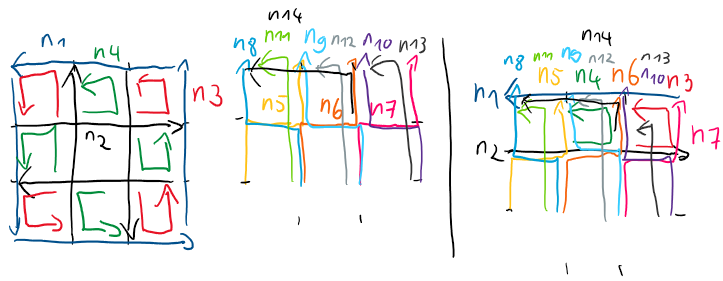

In [ ]:
class DQN(nn.Module):
    """ DQN implementation for a 2048 grid """

    def __init__(self, grid_shape: tuple[int, int], device: str) -> None:
        super().__init__()
        self.device = device
        assert grid_shape == (4,4)

        self.ttable = nn.ModuleList([
            nn.Embedding(num_embeddings=18**4, embedding_dim=1) for _ in range(7) # (n, 14, 4, 1) -> # (n, 14, 4, 1)
        ])
        self.ttable.to(self.device)
        self.powers = torch.tensor([18**3, 18**2, 18, 1]).view(1,1,1,4).to(self.device)

        self.net = nn.Sequential(
            nn.Flatten(), # (n, 14, 4) -> (n, 56)
            nn.ReLU(),
            nn.Linear(in_features=28, out_features=32),
            #nn.Linear(in_features=64, out_features=64),
            nn.Linear(in_features=32, out_features=1),
        )

        self.net.to(self.device)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """ Expects tensor of shape (n,14,4,4) """
        tuples = []
        x = (x[:, :, :, :] * self.powers).sum(dim=-1) # (n,14,4,4) -> (n,14,4)

        for i in range(7):
            ti = self.ttable[i].forward(x[:, i, :]).reshape(-1, 1, 4) # (n,1,4) -> (n,4,1) -> (n,4)
            
            # rotations = []
            # for r in range(4):
            #     test = x[:, [i], [r]]
            #     rotations.append(self.ttable[i].forward(x[:, i, r]))
            #ti = torch.cat(rotations, dim=-1)
            tuples.append(ti)
        x = torch.cat(tuples, dim=1)

        return self.net.forward(x)
    
    def V(self, x: np.ndarray, output_tensor: bool = False) -> np.ndarray|torch.Tensor:
        """ 
        Outputs the value function estimation by the model

        Args:
            x (np.ndarray): n-boards of shape (n,4,4) 

        Returns:
            V (np.ndarray): The value of the n-boards encoded as numpy array with shape (n,)
        
        """
        while len(x.shape) < 3: # (4,4) -> (1,4,4)
            x = x[None, ...]
        x = self.extract_tuples(x) # (n,4,4) -> (n,14,4,4)
        t = torch.from_numpy(x).int().to(self.device)
        #with torch.no_grad():
        vs = self.forward(t)
        vs = vs.squeeze(dim=-1)
        if output_tensor:
            return vs
        return vs.detach().numpy()
    

    def extract_tuples(self, grid: np.ndarray) -> np.ndarray:
        """
        Extract the n-tuples from n boards of shape (n, 4, 4). Returns the tuples as a numpy array of shape \n
        (n, ||n_tuple||, 4, 4) = (n, 14, 4, 4) \n
        with the third value representing the rotation (Top, Right, Bottom, Left) and the last values the ith value inside the n-tuple
        """
        assert len(grid.shape) >= 3 and grid.shape[1] == 4 and grid.shape[2] == 4
        n_tuples = np.zeros(shape=(grid.shape[0],7,4,4), dtype=grid.dtype)
        for k in range(4):
            g_v = np.rot90(grid, k=k, axes=(1,2))
            n_tuples[:,0,k] = g_v[:,0,::-1] # Outer
            n_tuples[:,1,k] = g_v[:,1,:: 1] # Inner
            n_tuples[:,2,k] = g_v[:, [1,1,0,0], [-2,-1,-1,-2]] # Edge
            n_tuples[:,3,k] = g_v[:, [1,1,0,0], [-3,-2,-2,-3]] # Inner Edge
            n_tuples[:,4,k] = g_v[:, [2,1,1,0], [0,0,1,1]] # Left Z
            n_tuples[:,5,k] = g_v[:, [2,1,1,0], [1,1,2,2]] # Middle Z
            n_tuples[:,6,k] = g_v[:, [2,1,1,0], [2,2,3,3]] # Right Z
            # n_tuples[:,7,k] = g_v[:, [2,1,1,0], [1,1,0,0]] # Left Mirror Z
            # n_tuples[:,8,k] = g_v[:, [2,1,1,0], [2,2,1,1]] # Middle Mirror Z
            # n_tuples[:,9,k] = g_v[:, [2,1,1,0], [3,3,2,2]] # Right Mirror Z
            # n_tuples[:,10,k] = g_v[:, [2,1,0,0], [1,1,1,0]] # Left Arrow
            # n_tuples[:,11,k] = g_v[:, [2,1,0,0], [2,2,2,1]] # Middle Arrow
            # n_tuples[:,12,k] = g_v[:, [2,1,0,0], [3,3,3,2]] # Right Arrow
            # n_tuples[:,13,k] = g_v[:, [1,0,0,0], [2,2,1,0]] # Edge Arrow
        return n_tuples
    
# Testing the implementation
net = DQN(grid_shape=env.game.shape, device="cpu")
net.V(env.game.grid)

array([-0.02220514], dtype=float32)

In [ ]:
class DQNAgent:
    """ Implements a simple DQN agent """
    
    def __init__( self,
                env: gym2048.Env2048, 
                learning_rate: float = 0.05, 
                gamma: float = 0.99,
                epsilon: float = 1.0,
                epsilon_decay = 0.005,
                epsilon_min = 0.001,
               ) -> None:
        self.env = env
        self.device = "cpu" #torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = DQN(grid_shape=env.game.grid.shape, device=self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.gamma = gamma
        self.history: list[Game] = []

        self.replay_buffer: deque[tuple[np.ndarray, int]] = deque(maxlen=10000)
        self.batch_size: int = 100

    def reset(self) -> None:
        if env.game.alive == False:
            self.replay_buffer.extend([(np.rot90(s.grid, k=k), env.game.score) for s in env.game.history for k in range(4)])
        env.reset()
        self.history.append(env.game)

    def update(self, game: Game) -> None:
        if len(self.replay_buffer) < self.batch_size:
            return
        batch = random.sample(self.replay_buffer, self.batch_size)
        grids, scores = cast(tuple[list[State], list[int]], zip(*batch))

        grids = np.array(grids)
        scores = np.array([score for score in scores])
        scores = torch.from_numpy(scores).float().to(self.device)

        #states = np.array([s.grid for s in game.history])
        #scores = np.array([game.score for i in range(len(game.history))])
        #scores = torch.from_numpy(scores).float().to(self.device)

        #weight_fn = lambda score: 0.2 + 0.8/(1+np.exp(-(np.log(score+1)-self.model.weight_mean)/self.model.weight_width))
        #weights = np.array([weight_fn(s.score) for s in game.history])
        #weights = torch.from_numpy(weights).float().to(self.device)

        vs = cast(torch.Tensor, self.model.V(grids, output_tensor=True))
        loss = nn.MSELoss()(vs, scores)
        #loss = (weights * (vs - scores) ** 2).mean()
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def step(self) -> bool:   
        next_state, reward, done, truncated, info = env.step(self.predict())
        return not(done or truncated)
    
    def predict(self) -> Action:
        possible_moves = self.env.game.get_moves()
        mask = np.array([(1 if a in possible_moves else 0) for a in Action])
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample(mask=mask)
        actions = self.get_qv()
        return max(actions, key=actions.get)
    
    def get_qv(self) -> dict[Action, float]:
        qvs = {}
        for a in Action:
            next_states = self.env.game.state.get_next_states(a)
            if len(next_states) == 1:
                continue
            next_states_grid = np.array([s.grid for s in next_states.keys()])
            v = self.model.V(next_states_grid)
            qvs[a] = np.sum([p*v for p, v in zip(next_states.values(), v)])
        return qvs
    
    @property
    def scores(self) -> list[float]:
        return [g.score for g in self.history]
    
    @property
    def highest_tiles(self) -> list[int]:
        return [g.highest_tile for g in self.history]
    
    @property
    def move_counts(self) -> list[int]:
        return [g.move_count for g in self.history] 
    
    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * (1 - self.epsilon_decay))


    def adjust_training_weights(self) -> None:
        pass
        #self.model.weight_mean = np.log(max(100, np.mean(self.scores[-500:])))
        #self.model.weight_width = 2


env = gym2048.Env2048(shape=(4,4))
agent = DQNAgent(env=env, gamma=0.99, learning_rate=0.001, epsilon=0.2, epsilon_decay=0.01, epsilon_min=0.05)
episode = -1

In [ ]:
agent.predict()

<Action.RIGHT: 3>

Episode 1582/3000 - Score: 2312 - Highest tile: 256 - Length: 194 - Epsilon: 0.050 - Average rolling score: 1402.960
Episode 1583/3000 - Score: 1276 - Highest tile: 128 - Length: 133 - Epsilon: 0.050 - Average rolling score: 1401.840
Episode 1584/3000 - Score: 1308 - Highest tile: 128 - Length: 132 - Epsilon: 0.050 - Average rolling score: 1384.800
Episode 1585/3000 - Score: 2172 - Highest tile: 256 - Length: 185 - Epsilon: 0.050 - Average rolling score: 1402.240
Episode 1586/3000 - Score: 1116 - Highest tile: 128 - Length: 118 - Epsilon: 0.050 - Average rolling score: 1396.000
Episode 1587/3000 - Score: 2260 - Highest tile: 256 - Length: 184 - Epsilon: 0.050 - Average rolling score: 1411.920
Episode 1588/3000 - Score: 1024 - Highest tile: 128 - Length: 109 - Epsilon: 0.050 - Average rolling score: 1404.560
Episode 1589/3000 - Score: 668 - Highest tile: 64 - Length: 90 - Epsilon: 0.050 - Average rolling score: 1400.000
Episode 1590/3000 - Score: 892 - Highest tile: 64 - Length: 109 - E

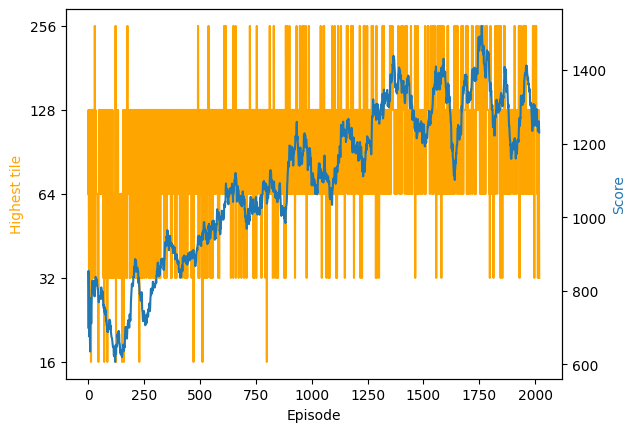

In [ ]:
episode += 1
episode_cap = 3000
try:
    for episode in range(episode, episode_cap):
        agent.reset()

        while env.game.alive:
            done = agent.step()
        for i in range(10):
            agent.update(env.game)
        agent.decay_epsilon()
        #agent.adjust_training_weights()

        s = f"Episode {episode}/{episode_cap}"
        for lbl, v in [
            ("Score", env.game.score), 
            ("Highest tile", env.game.highest_tile), 
            ("Length", env.game.move_count), 
            ("Epsilon", f"{agent.epsilon:1.3f}"),
            ("Average rolling score", f"{np.mean(agent.scores[max(0,episode-50):]):1.3f}")
        ]:
            s += f" - {lbl}: {v}"
        print(s)

except KeyboardInterrupt:
    pass

ax1 = plt.subplot()
ax2 = ax1.twinx()
p1 = ax1.plot(np.log2(agent.highest_tiles), label="Highest tile", c="orange")
scores = agent.scores
p2 = ax2.plot([np.mean(scores[max(0,i-50):i]) for i in range(1,len(scores)+1)], label="Scores")
ax1.set_xlabel("Episode")
ax1.set_ylabel("Highest tile")
ax2.set_ylabel("Score")
ax1.yaxis.label.set_color(p1[0].get_color())
ax2.yaxis.label.set_color(p2[0].get_color())
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{2**x:n}"))
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

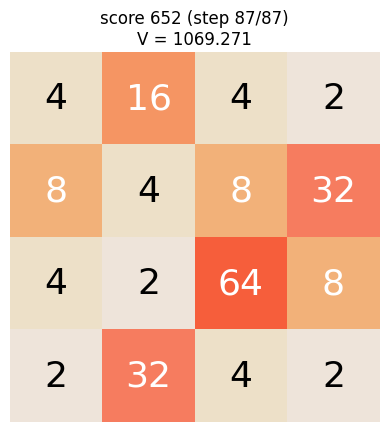

In [ ]:
p = Path(r"C:\Users\abril\OneDrive - JGU\Studium\Aktuelle Module\Reinforcement Learning SoSe25\Projekt\Videos\2025-07-20 DQN embedding v1.mp4")
if p.exists():
    raise FileExistsError("File already exists")
agent.history[-2].render_game(value_func=lambda x: f"V = {agent.model.V(x)[0]:1.3f}").save(p)

In [ ]:
t = torch.from_numpy(np.array([0,18,18**2,18**3]))

agent.model.ttable[0].forward(t)

tensor([[-0.8517],
        [ 2.1055],
        [-0.7378],
        [-1.4458]], grad_fn=<EmbeddingBackward0>)

In [ ]:
t = torch.from_numpy(np.array([0,18,18**2,18**3]))

agent.model.ttable[0].forward(t)

tensor([[-0.8517],
        [ 1.8406],
        [-0.7378],
        [-1.4458]], grad_fn=<EmbeddingBackward0>)

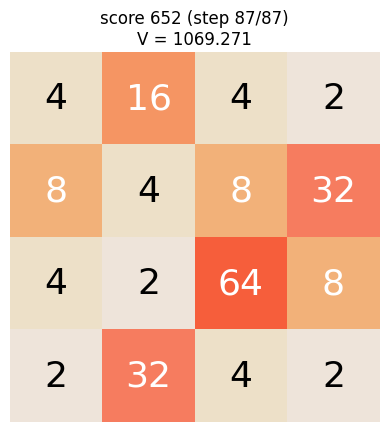

In [ ]:
HTML(agent.history[-2].render_game(value_func=lambda x: f"V = {agent.model.V(x)[0]:1.3f}").to_jshtml())

### 3 Remove embeddings again

In [ ]:
class DQN(nn.Module):
    """ DQN implementation for a 2048 grid """

    def __init__(self, grid_shape: tuple[int, int], device: str) -> None:
        super().__init__()
        self.device = device
        assert grid_shape == (4,4)
        self.n_features = 7

        self.feature_nets = nn.ModuleList([
            nn.Conv2d(in_channels=self.n_features, out_channels=self.n_features, kernel_size=(1,1)), # (n,14,4,4) -> (n,14,4,4)
            nn.Conv2d(in_channels=self.n_features, out_channels=self.n_features, kernel_size=(1,2)), # (n,14,4,4) -> (n,14,4,3)
            nn.Conv2d(in_channels=self.n_features, out_channels=self.n_features, kernel_size=(1,3)), # (n,14,4,4) -> (n,14,4,2)
            nn.Conv2d(in_channels=self.n_features, out_channels=self.n_features, kernel_size=(1,4)), # (n,14,4,4) -> (n,14,4,1)
        ])

        self.net = nn.Sequential(
            nn.Flatten(), # (n, 14, 4) -> (n, 56)
            nn.Linear(in_features=self.n_features*4*10, out_features=128),
            #nn.Linear(in_features=64, out_features=64),
            nn.Linear(in_features=128, out_features=1),
        )

        self.net.to(self.device)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """ Expects tensor of shape (n,14,4,4) """
        x = torch.cat([c.forward(x) for c in self.feature_nets], dim=-1) # (n,14,4,4) -> (n,14,4,10)

        return self.net.forward(x)
    
    def V(self, x: np.ndarray, output_tensor: bool = False) -> np.ndarray|torch.Tensor:
        """ 
        Outputs the value function estimation by the model

        Args:
            x (np.ndarray): n-boards of shape (n,4,4) 

        Returns:
            V (np.ndarray): The value of the n-boards encoded as numpy array with shape (n,)
        
        """
        while len(x.shape) < 3: # (4,4) -> (1,4,4)
            x = x[None, ...]
        x = self.extract_tuples(x) # (n,4,4) -> (n,14,4,4)
        t = torch.from_numpy(x).float().to(self.device)
        #with torch.no_grad():
        vs = self.forward(t)
        vs = vs.squeeze(dim=-1)
        if output_tensor:
            return vs
        return vs.detach().numpy()
    

    def extract_tuples(self, grid: np.ndarray) -> np.ndarray:
        """
        Extract the n-tuples from n boards of shape (n, 4, 4). Returns the tuples as a numpy array of shape \n
        (n, |n_tuple|, 4, 4) = (n, 14, 4, 4) \n
        with the third value representing the rotation (Top, Right, Bottom, Left) and the last values the ith value inside the n-tuple
        """
        assert len(grid.shape) >= 3 and grid.shape[1] == 4 and grid.shape[2] == 4
        n_tuples = np.zeros(shape=(grid.shape[0],self.n_features,4,4), dtype=grid.dtype)
        for k in range(4):
            g_v = np.rot90(grid, k=k, axes=(1,2))
            n_tuples[:,0,k] = g_v[:,0,::-1] # Outer
            n_tuples[:,1,k] = g_v[:,1,:: 1] # Inner
            n_tuples[:,2,k] = g_v[:, [1,1,0,0], [-2,-1,-1,-2]] # Edge
            n_tuples[:,3,k] = g_v[:, [1,1,0,0], [-3,-2,-2,-3]] # Inner Edge
            n_tuples[:,4,k] = g_v[:, [2,1,1,0], [0,0,1,1]] # Left Z
            n_tuples[:,5,k] = g_v[:, [2,1,1,0], [1,1,2,2]] # Middle Z
            n_tuples[:,6,k] = g_v[:, [2,1,1,0], [2,2,3,3]] # Right Z
            # n_tuples[:,7,k] = g_v[:, [2,1,1,0], [1,1,0,0]] # Left Mirror Z
            # n_tuples[:,8,k] = g_v[:, [2,1,1,0], [2,2,1,1]] # Middle Mirror Z
            # n_tuples[:,9,k] = g_v[:, [2,1,1,0], [3,3,2,2]] # Right Mirror Z
            # n_tuples[:,10,k] = g_v[:, [2,1,0,0], [1,1,1,0]] # Left Arrow
            # n_tuples[:,11,k] = g_v[:, [2,1,0,0], [2,2,2,1]] # Middle Arrow
            # n_tuples[:,12,k] = g_v[:, [2,1,0,0], [3,3,3,2]] # Right Arrow
            # n_tuples[:,13,k] = g_v[:, [1,0,0,0], [2,2,1,0]] # Edge Arrow

        return n_tuples
    
# Testing the implementation
net = DQN(grid_shape=env.game.shape, device="cpu")
net.V(env.game.grid)

array([-0.0306829], dtype=float32)

In [ ]:
class DQNAgent:
    """ Implements a simple DQN agent """
    
    def __init__( self,
                env: gym2048.Env2048, 
                learning_rate: float = 0.05, 
                gamma: float = 0.99,
                epsilon: float = 1.0,
                epsilon_decay = 0.005,
                epsilon_min = 0.001,
               ) -> None:
        self.env = env
        self.device = "cpu" #torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = DQN(grid_shape=env.game.grid.shape, device=self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.gamma = gamma
        self.history: list[Game] = []

        self.replay_buffer: deque[tuple[State, int]] = deque(maxlen=10_000)
        self.batch_size: int = 200
        self._loss = 0

    def reset(self) -> None:
        if env.game.alive == False:
            #self.replay_buffer.extend([(s.clone(rot=k), env.game.score) for s in env.game.history for k in range(4)])
            self.replay_buffer.extend([(s, env.game.score - s.score) for s in env.game.history])
        env.reset()
        self.history.append(env.game)

    def update(self, game: Game, mode: Literal["Batch", "Last"] = "Last") -> None:
        match mode:
            case "Batch":
                if len(self.replay_buffer) < self.batch_size:
                    return
                #weights = np.log2([s.highest_tile for s, score in self.replay_buffer])
                batch = random.choices(self.replay_buffer, k=self.batch_size)
                states, scores = cast(tuple[list[State], list[int]], zip(*batch))

                grids = np.array([s.grid for s in states])
                scores = np.array([score for score in scores])
                scores = torch.from_numpy(scores).float().to(self.device)
            case "Last":
                grids = np.array([s.grid for s in game.history])
                scores = np.array([game.score for i in range(len(game.history))])
                scores = torch.from_numpy(scores).float().to(self.device)

        #weight_fn = lambda score: 0.2 + 0.8/(1+np.exp(-(np.log(score+1)-self.model.weight_mean)/self.model.weight_width))
        #weights = np.array([weight_fn(s.score) for s in game.history])
        #weights = torch.from_numpy(weights).float().to(self.device)

        vs = cast(torch.Tensor, self.model.V(grids, output_tensor=True))
        loss: torch.Tensor = nn.MSELoss()(vs, scores)
        self._loss = loss.detach().numpy()
        #loss = ((vs - scores) ** 2).mean()
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def step(self) -> bool:   
        next_state, reward, done, truncated, info = env.step(self.predict())
        return not(done or truncated)
    
    def predict(self) -> Action:
        possible_moves = self.env.game.get_moves()
        mask = np.array([(1 if a in possible_moves else 0) for a in Action])
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample(mask=mask)
        actions = self.get_qv()
        return max(actions, key=actions.get)
    
    def get_qv(self) -> dict[Action, float]:
        qvs = {}
        for a in Action:
            next_states = self.env.game.state.get_next_states(a)
            if len(next_states) == 1:
                continue
            next_states_grid = np.array([s.grid for s in next_states.keys()])
            v = self.model.V(next_states_grid)
            qvs[a] = np.sum([p*v for p, v in zip(next_states.values(), v)])
        return qvs
    
    @property
    def scores(self) -> list[float]:
        return [g.score for g in self.history]
    
    @property
    def highest_tiles(self) -> list[int]:
        return [g.highest_tile for g in self.history]
    
    @property
    def move_counts(self) -> list[int]:
        return [g.move_count for g in self.history] 
    
    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * (1 - self.epsilon_decay))


    def adjust_training_weights(self) -> None:
        pass
        #self.model.weight_mean = np.log(max(100, np.mean(self.scores[-500:])))
        #self.model.weight_width = 2


env = gym2048.Env2048(shape=(4,4))
agent = DQNAgent(env=env, gamma=0.99, learning_rate=0.001, epsilon=0.05, epsilon_decay=0, epsilon_min=0.05)
episode = -1

In [ ]:
dq = deque(maxlen=10_000)
dq.extend(agent.replay_buffer)
agent.replay_buffer = dq

Episode 2647/10000 - Score:  1700 - Highest tile:  128 - Length: 163 - Epsilon: 0.050 - Average rolling score: 1823.059 - √Loss:   788.4
Episode 2648/10000 - Score:  2544 - Highest tile:  256 - Length: 214 - Epsilon: 0.050 - Average rolling score: 1851.373 - √Loss:   772.5
Episode 2649/10000 - Score:  1408 - Highest tile:  128 - Length: 146 - Epsilon: 0.050 - Average rolling score: 1847.922 - √Loss:   770.0
Episode 2650/10000 - Score:  2752 - Highest tile:  256 - Length: 223 - Epsilon: 0.050 - Average rolling score: 1825.020 - √Loss:   826.7
Episode 2651/10000 - Score:  1368 - Highest tile:  128 - Length: 144 - Epsilon: 0.050 - Average rolling score: 1803.529 - √Loss:   807.5
Episode 2652/10000 - Score:  1188 - Highest tile:  128 - Length: 129 - Epsilon: 0.050 - Average rolling score: 1750.275 - √Loss:   733.9
Episode 2653/10000 - Score:  1632 - Highest tile:  128 - Length: 166 - Epsilon: 0.050 - Average rolling score: 1743.373 - √Loss:   779.5
Episode 2654/10000 - Score:  3328 - Highe

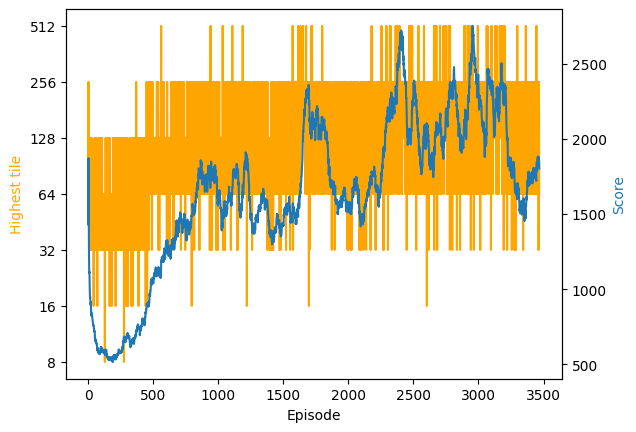

In [ ]:
episode += 1
episode_cap = 10_000
try:
    for episode in range(episode, episode_cap):
        agent.reset()

        while env.game.alive:
            done = agent.step()
        agent.update(env.game, mode="Batch")
        agent.decay_epsilon()
        #agent.adjust_training_weights()

        s = f"Episode {episode:>4}/{episode_cap}"
        for v in [
            f"Score: {env.game.score:5}", 
            f"Highest tile: {env.game.highest_tile:4}",
            f"Length: {env.game.move_count:3}",
            f"Epsilon: {agent.epsilon:1.3f}",
            f"Average rolling score: {np.mean(agent.scores[max(0,episode-50):]):1.3f}",
            f"√Loss: {np.sqrt(agent._loss):7.1f}",
        ]:
            s += f" - {v}"
        print(s)

except KeyboardInterrupt:
    pass

ax1 = plt.subplot()
ax2 = ax1.twinx()
p1 = ax1.plot(np.log2(agent.highest_tiles), label="Highest tile", c="orange")
scores = agent.scores
p2 = ax2.plot([np.mean(scores[max(0,i-50):i]) for i in range(1,len(scores)+1)], label="Scores")
ax1.set_xlabel("Episode")
ax1.set_ylabel("Highest tile")
ax2.set_ylabel("Score")
ax1.yaxis.label.set_color(p1[0].get_color())
ax2.yaxis.label.set_color(p2[0].get_color())
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{2**x:n}"))
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

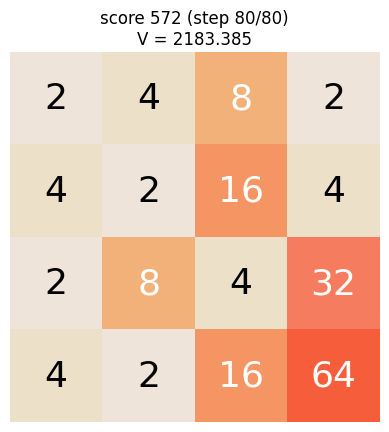

In [ ]:
HTML(agent.history[-2].render_game(value_func=lambda x: f"V = {agent.model.V(x)[0]:1.3f}").to_jshtml())

In [ ]:
class DQN(nn.Module):
    """ DQN implementation for a 2048 grid """

    def __init__(self, grid_shape: tuple[int, int], device: str) -> None:
        super().__init__()
        self.device = device
        assert grid_shape == (4,4)
        self.n_features = 7

        self.feature_nets = nn.ModuleList([
            nn.Linear(), # (n,14,4,12) -> (n,14,4,3)
            nn.Conv2d(in_channels=self.n_features, out_channels=self.n_features, kernel_size=(1,2)), # (n,14,4,4) -> (n,14,4,3)
        ])

        self.net = nn.Sequential(
            nn.Flatten(), # (n, 14, 4) -> (n, 56)
            nn.Linear(in_features=self.n_features*4*10, out_features=128),
            #nn.Linear(in_features=64, out_features=64),
            nn.Linear(in_features=128, out_features=1),
        )

        self.net.to(self.device)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """ Expects tensor of shape (n,14,4,4) """
        x = torch.cat([c.forward(x) for c in self.feature_nets], dim=-1) # (n,14,4,4) -> (n,14,4,10)

        return self.net.forward(x)
    
    def V(self, x: np.ndarray, output_tensor: bool = False) -> np.ndarray|torch.Tensor:
        """ 
        Outputs the value function estimation by the model

        Args:
            x (np.ndarray): n-boards of shape (n,4,4) 

        Returns:
            V (np.ndarray): The value of the n-boards encoded as numpy array with shape (n,)
        
        """
        while len(x.shape) < 3: # (4,4) -> (1,4,4)
            x = x[None, ...]
        x = self.extract_tuples(x) # (n,4,4) -> (n,14,4,4)
        t = torch.from_numpy(x).float().to(self.device)
        #with torch.no_grad():
        vs = self.forward(t)
        vs = vs.squeeze(dim=-1)
        if output_tensor:
            return vs
        return vs.detach().numpy()
    

    def extract_tuples(self, grid: np.ndarray) -> np.ndarray:
        """
        Extract the n-tuples from n boards of shape (n, 4, 4). Returns the tuples as a numpy array of shape \n
        (n, |n_tuple|, 4, 4) = (n, 14, 4, 4) \n
        with the third value representing the rotation (Top, Right, Bottom, Left) and the last values the ith value inside the n-tuple
        """
        assert len(grid.shape) >= 3 and grid.shape[1] == 4 and grid.shape[2] == 4
        n_tuples = np.zeros(shape=(grid.shape[0],self.n_features,4,3), dtype=grid.dtype)
        for k in range(4):
            g_v = np.rot90(grid, k=k, axes=(1,2))
            n_tuples[:,0,k] = g_v[:,0,::-1] # Outer
            n_tuples[:,1,k] = g_v[:,1,:: 1] # Inner
            n_tuples[:,2,k] = g_v[:, [1,1,0,0], [-2,-1,-1,-2]] # Edge
            n_tuples[:,3,k] = g_v[:, [1,1,0,0], [-3,-2,-2,-3]] # Inner Edge
            n_tuples[:,4,k] = g_v[:, [2,1,1,0], [0,0,1,1]] # Left Z
            n_tuples[:,5,k] = g_v[:, [2,1,1,0], [1,1,2,2]] # Middle Z
            n_tuples[:,6,k] = g_v[:, [2,1,1,0], [2,2,3,3]] # Right Z
            n_tuples[:,7,k] = g_v[:, [2,1,1,0], [1,1,0,0]] # Left Mirror Z
            n_tuples[:,8,k] = g_v[:, [2,1,1,0], [2,2,1,1]] # Middle Mirror Z
            n_tuples[:,9,k] = g_v[:, [2,1,1,0], [3,3,2,2]] # Right Mirror Z
            n_tuples[:,10,k] = g_v[:, [2,1,0,0], [1,1,1,0]] # Left Arrow
            n_tuples[:,11,k] = g_v[:, [2,1,0,0], [2,2,2,1]] # Middle Arrow
            n_tuples[:,12,k] = g_v[:, [2,1,0,0], [3,3,3,2]] # Right Arrow
            n_tuples[:,13,k] = g_v[:, [1,0,0,0], [2,2,1,0]] # Edge Arrow

        n_tuples[:, :, :, :4] = np.diff(n_tuples[:,:,:,:4], axis=-1, prepend=0)
        n_tuples[:, :, :, 4:4] = np.diff(n_tuples[:,:,:,:4], axis=-1, prepend=0)
        return n_tuples
    
# Testing the implementation
net = DQN(grid_shape=env.game.shape, device="cpu")
print(net.extract_tuples(env.game.grid[None, :]))
net.V(env.game.grid)